<a href="https://colab.research.google.com/github/taekjunkim/artiphysiology2020/blob/main/get_Alexnet_max_then_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

stim_path ='/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Naturalistic/'

import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.get_device_name(0)    
else:
    device = torch.device("cpu")

import torchvision.models as models

import numpy as np;

import torch.nn as nn

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose(
    #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    #to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
    #if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    # or if the numpy.ndarray has dtype = np.uint8
    [transforms.Resize(224),
     transforms.CenterCrop(224), 
     #normalization of pre-trained networks:
     #from docs:
     #All pre-trained models expect input images normalized in the same way, 
     #i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where
     #H and W are expected to be at least 224. The images have to be loaded 
     #in to a range of [0, 1] and then normalized using 
     #mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])#

"""
# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root=stim_path, transform=data_transforms)
# Comment 2: Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=50, shuffle=False);
"""

### modification of Imagefolder to get image path
class ImageFolderWithPaths(datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0].split('Naturalistic')[1]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
image_datasets = ImageFolderWithPaths(root=stim_path, transform=data_transforms)    

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False, num_workers=2);    

In [ ]:
print(image_datasets.imgs[21])

('/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Naturalistic/001.ak47/001_0022.jpg', 0)


In [ ]:
image_datasets.imgs[0][0].split('Naturalistic')[1]
print(len(image_datasets.imgs))

71392


In [ ]:
alexnet = models.alexnet(pretrained=True);
alexnet.eval();
alexnet.to(device)

layers_of_interest = [3,6,8,10]; # layers where RF size > 50 pix

Max_outputs = []; #simple function to store outputs
Min_outputs = []; #simple function to store outputs
def store_output(module,input,output):
    newSize = (np.shape(output)[0],
               np.shape(output)[1],
               np.shape(output)[2]*np.shape(output)[3]);
    output = output.view(newSize);           
    Max_outputs.append(torch.max(output,2)[0]);
    Min_outputs.append(torch.min(output,2)[0]);    

for i,layer in enumerate(alexnet.features):
    if i in layers_of_interest:
        print(layer)
        layer.register_forward_hook(store_output);
    #if isinstance(layer,nn.ReLU):
    #    layer.inplace = False;    


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_Max_outputs = [];
alexnet_Min_outputs = [];
alexnet_used_images = [];
for i, (images,labels,path) in enumerate(dataloaders):

    alexnet_used_images += list(path);

    if torch.cuda.is_available():  
        images = images.cuda();
    #images = Variable(images.float());
    #Test input
    Max_outputs = [];
    Min_outputs = [];    
    out = alexnet(images)

    print('batch(size 10) # '+str(i)+' was processed')

    if torch.cuda.is_available():  
        for j in range(len(Max_outputs)):
            Max_outputs[j] = Max_outputs[j].cpu();
            Min_outputs[j] = Min_outputs[j].cpu();            

    if i==0:
        alexnet_Max_outputs = Max_outputs;
        alexnet_Min_outputs = Min_outputs;        
        for j in range(len(Max_outputs)):
            alexnet_Max_outputs[j] = alexnet_Max_outputs[j].detach().numpy();
            alexnet_Min_outputs[j] = alexnet_Min_outputs[j].detach().numpy();            
    else:
        for j in range(len(Max_outputs)):
            alexnet_Max_outputs[j] = np.append(alexnet_Max_outputs[j],Max_outputs[j].detach().numpy(),axis=0);
            alexnet_Min_outputs[j] = np.append(alexnet_Min_outputs[j],Min_outputs[j].detach().numpy(),axis=0);            


os.chdir(stim_path)
np.savez('alexnet_Naturalistic_Max_outputs.npz',images=alexnet_used_images,
                                             conv2=alexnet_Max_outputs[0],
                                             conv3=alexnet_Max_outputs[1],
                                             conv4=alexnet_Max_outputs[2],
                                             conv5=alexnet_Max_outputs[3]);
np.savez('alexnet_Naturalistic_Min_outputs.npz',images=alexnet_used_images,
                                             conv2=alexnet_Min_outputs[0],
                                             conv3=alexnet_Min_outputs[1],
                                             conv4=alexnet_Min_outputs[2],
                                             conv5=alexnet_Min_outputs[3]);

Streaming output truncated to the last 5000 lines.
batch(size 10) # 2141 was processed
batch(size 10) # 2142 was processed
batch(size 10) # 2143 was processed
batch(size 10) # 2144 was processed
batch(size 10) # 2145 was processed
batch(size 10) # 2146 was processed
batch(size 10) # 2147 was processed
batch(size 10) # 2148 was processed
batch(size 10) # 2149 was processed
batch(size 10) # 2150 was processed
batch(size 10) # 2151 was processed
batch(size 10) # 2152 was processed
batch(size 10) # 2153 was processed
batch(size 10) # 2154 was processed
batch(size 10) # 2155 was processed
batch(size 10) # 2156 was processed
batch(size 10) # 2157 was processed
batch(size 10) # 2158 was processed
batch(size 10) # 2159 was processed
batch(size 10) # 2160 was processed
batch(size 10) # 2161 was processed
batch(size 10) # 2162 was processed
batch(size 10) # 2163 was processed
batch(size 10) # 2164 was processed
batch(size 10) # 2165 was processed
batch(size 10) # 2166 was processed
batch(size 10

In [ ]:
### visualization
import torch
from torch.autograd import Variable;
from torch.nn import ReLU
from torchvision import models

import os

from PIL import Image
import numpy as np;
import matplotlib.pyplot as plt;

import torchvision.transforms as transforms

stim_path ='/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Naturalistic/'

data_transforms = transforms.Compose(
    #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    #to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
    #if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    # or if the numpy.ndarray has dtype = np.uint8
    [transforms.Resize(224),
     transforms.CenterCrop(224), 
     #normalization of pre-trained networks:
     #from docs:
     #All pre-trained models expect input images normalized in the same way, 
     #i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where
     #H and W are expected to be at least 224. The images have to be loaded 
     #in to a range of [0, 1] and then normalized using 
     #mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])#


In [ ]:
def norm_im(im):
    im = im - im.min()
    im = im /im.max()
    return im

def resize_crop_im(im):
    h = im.size[0];
    w = im.size[1];

    if h>w:
        im = im.resize((int(224*h/w),224));
    else:
        im = im.resize((224,int(224*w/h)));

    left = (im.size[0] - 224)/2
    top = (im.size[1] - 224)/2
    right = (im.size[0] + 224)/2
    bottom = (im.size[1] + 224)/2    

    im = im.crop((left,top,right,bottom));
    return im

def filter_boundary(Fout,rf_size,stride,target_layer,HighLow):
    Fout = Fout.detach().numpy();
    rf_radius = rf_size[target_layer]/2;
    rf_stride = stride[target_layer];

    if HighLow==1:
        (posY,posX) = np.where(Fout==np.max(Fout));
    else:
        (posY,posX) = np.where(Fout==np.min(Fout));

    Fout_center = np.shape(Fout)[0]/2 - 0.5;

    posY_img = 224/2 + (posY-Fout_center)*rf_stride;
    posX_img = 224/2 + (posX-Fout_center)*rf_stride;

    Y_img = [posY_img-rf_radius,posY_img+rf_radius];    
    X_img = [posX_img-rf_radius,posX_img+rf_radius];      

    return Y_img, X_img  


### Original code source: https://github.com/utkuozbulak/pytorch-cnn-visualizations.git
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.outputs = []
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_layer, target_filter, HighLow):
        self.model.zero_grad()
        # Forward pass
        x = input_image
        for index, layer in enumerate(self.model.features):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == target_layer:
                # (forward hook function triggered)
                break
        self.outputs = x;

        # Target for backprop - find max response from the target layer, target filter
        if HighLow == 1:
            pos = np.where(x[0,target_filter,:,:]==x[0,target_filter,:,:].max())[:];
        elif HighLow == 0:
            pos = np.where(x[0,target_filter,:,:]==x[0,target_filter,:,:].min())[:];

        one_hot_output = torch.FloatTensor(x.shape).zero_()
        #one_hot_output[0,target_filter,pos[0][0],pos[1][0]] = 1;
        one_hot_output[0,target_filter,pos[0][0],pos[1][0]] = x[0,target_filter,pos[0][0],pos[1][0]]

        # Backward pass
        x.backward(gradient=one_hot_output)

        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

alexnet = models.alexnet(pretrained=True);
device = torch.device("cpu")
alexnet.to(device);


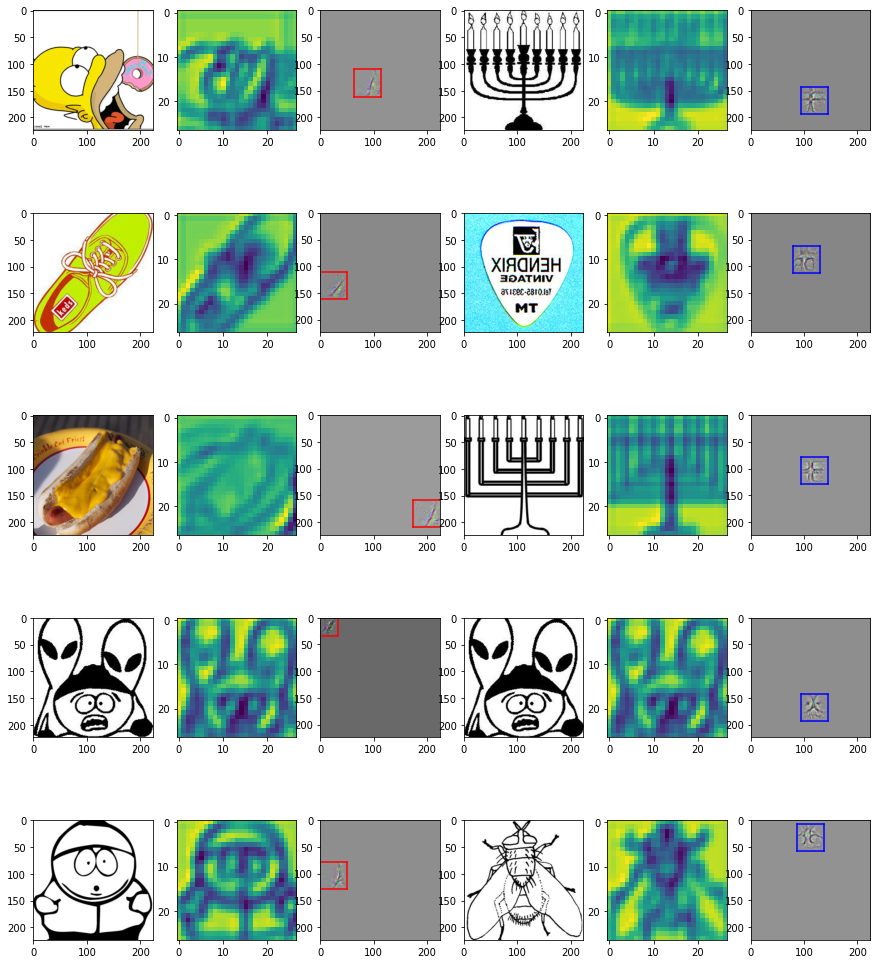

In [ ]:
layers_of_interest = {'conv2':3,'conv3':6,'conv4':8,'conv5':10}; # 3,6,8,10
rf_size = {'conv2':51,'conv3':99,'conv4':131,'conv5':163};
stride = {'conv2':8,'conv3':16,'conv4':16,'conv5':16};
target_layer = 'conv2'
target_filter = 63


os.chdir(stim_path);
Max_data = np.load('alexnet_Naturalistic_Max_outputs.npz');
Min_data = np.load('alexnet_Naturalistic_Min_outputs.npz');
layer_idx = layers_of_interest[target_layer];

alexnet_used_images = Max_data['images'];
Max_filter_output = Max_data[target_layer][:,target_filter];
Min_filter_output = Min_data[target_layer][:,target_filter];

#filter_output = alexnet_outputs[layer_idx][:,target_filter];
Max_img_ids = Max_filter_output.argsort()[::-1][:5]
Min_img_ids = Min_filter_output.argsort()[:5];
img_ids = np.concatenate((Max_img_ids,Min_img_ids));



GBP = GuidedBackprop(alexnet)

plt.figure(figsize=(15,18));
for i in range(len(img_ids)):

    img_path = stim_path+alexnet_used_images[img_ids[i]];
    original_image = Image.open(img_path).convert('RGB');
    prep_img = data_transforms(original_image);
    prep_img.unsqueeze_(0)
    prep_img = Variable(prep_img, requires_grad=True)

    # Get gradients
    if i<len(img_ids)/2:  ## looking for good stim
        guided_grads = GBP.generate_gradients(prep_img, layer_idx, target_filter,1);
    else:  ## looking for bad stim
        guided_grads = GBP.generate_gradients(prep_img, layer_idx, target_filter,0);          

    # Original image
    if i<len(img_ids)/2:  ## looking for good stim
        plt.subplot(5,6,i*6+1);
    else:
        plt.subplot(5,6,(i-5)*6+1+3);
    plt.imshow(resize_crop_im(original_image))

    # Unit output
    if i<len(img_ids)/2:  ## looking for good stim
        plt.subplot(5,6,i*6+2);
    else:
        plt.subplot(5,6,(i-5)*6+2+3);
    Fout = GBP.outputs[-1][target_filter,:,:];
    plt.imshow(Fout.detach().numpy()) 

    # Backpropagated
    if i<len(img_ids)/2:  ## looking for good stim
        plt.subplot(5,6,i*6+3);
    else:
        plt.subplot(5,6,(i-5)*6+3+3);
    im = norm_im(guided_grads)
    im = np.moveaxis(im,0,-1)
    plt.imshow(im);

    if i<len(img_ids)/2:  ## looking for good stim    
        Y_img, X_img = filter_boundary(Fout,rf_size,stride,target_layer,1);    
        plt.plot(X_img,[Y_img[0],Y_img[0]],'r');
        plt.plot(X_img,[Y_img[1],Y_img[1]],'r');    
        plt.plot([X_img[0],X_img[0]],Y_img,'r');
        plt.plot([X_img[1],X_img[1]],Y_img,'r');
    else:
        Y_img, X_img = filter_boundary(Fout,rf_size,stride,target_layer,0);          
        plt.plot(X_img,[Y_img[0],Y_img[0]],'b');
        plt.plot(X_img,[Y_img[1],Y_img[1]],'b');    
        plt.plot([X_img[0],X_img[0]],Y_img,'b');
        plt.plot([X_img[1],X_img[1]],Y_img,'b');
    plt.xlim((0,224));
    plt.ylim((0,224));
    plt.gca().invert_yaxis();

del Max_data, Min_data
    

In [ ]:
print(Y_img)

[array([62.5]), array([193.5])]


In [ ]:
#Fout = Fout.detach().numpy()
np.where(Fout==np.max(Fout))

(array([3]), array([8]))